# References
https://geodata.lib.berkeley.edu/catalog/stanford-gn214np6763 (for tanzania polygon)\
https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html (for handling shape files)\
https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3 (for pandas-profiling)

In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from shapely.geometry import Point, shape, LineString
import folium
import matplotlib.pyplot as plt

# from pandas_profiling import ProfileReport


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

Tanzania_coord = (-6.3690,34.8888)

pd.set_option('display.max_columns', None)
# pd.reset_option(“max_columns”)
sns.set(rc={'figure.figsize':(11,8)})

In [2]:
X_train_raw = pd.read_csv('data/Training_set.csv')
y_train_raw = pd.read_csv('data/Training_labels.csv')

X_test_raw = pd.read_csv('data/Test_set.csv')

df_train = pd.merge(X_train_raw,y_train_raw,on='id')

In [3]:
df_train.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

'functional needs repair' will probably need smoting

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
df_train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [ ]:
# ProfileReport(df_train)

In [6]:
df_train.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [ ]:
df_train[df_train.population>1000].status_group.value_counts(normalize=True)

# Column Analysis

## ID
Too unique and spread. No good for prediction. Drop

## amount_tsh

In [7]:
df_train.amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [8]:
(df_train.amount_tsh==0).sum()/df_train.shape[0]

0.700993265993266

skewed. 70% zeros. **Drop?**

### funder

In [9]:
df_train.funder.value_counts(normalize=True)

Government Of Tanzania            0.162898
Danida                            0.055841
Hesawa                            0.039487
Rwssp                             0.024639
World Bank                        0.024191
                                    ...   
Tabea                             0.000018
Sent Tho                          0.000018
Christan Outrich                  0.000018
Saidi Halfani                     0.000018
Tanzania Egypt Technical Co Op    0.000018
Name: funder, Length: 1897, dtype: float64

In [10]:
df_train.funder.isna().sum()/df_train.shape[0]

0.0611952861952862

Missing 6% of data. Most frequent value is 16% of dataframe. 2nd is 5%.

1897 unique labels. **Drop**

### gps_height

In [11]:
df_train.gps_height.value_counts(normalize=True)

 0       0.344074
-15      0.001010
-16      0.000926
-13      0.000926
-20      0.000875
           ...   
 2285    0.000017
 2424    0.000017
 2552    0.000017
 2413    0.000017
 2385    0.000017
Name: gps_height, Length: 2428, dtype: float64

34% is zero. Valid values?

In [12]:
(df_train.gps_height<0).sum()/df_train.shape[0]

0.025185185185185185

2.5% of gps_height is negative. 0 sounds like a valid value. Lakes?

### installer

In [13]:
df_train.installer.value_counts()

DWE                           17402
Government                     1825
RWE                            1206
Commu                          1060
DANIDA                         1050
                              ...  
Mama Hamisa                       1
Amadi                             1
COW                               1
AFRICA MUSLIM                     1
MKONGO BUILDING CONTRACTOR        1
Name: installer, Length: 2145, dtype: int64

2145 unique installers. No good way to bin it. OHE -> 2100 new columns to manage. **Drop**

### latitude & longitude

### wpt_name

In [14]:
df_train.wpt_name.value_counts(normalize=True)

none                        0.059983
Shuleni                     0.029428
Zahanati                    0.013973
Msikitini                   0.009007
Kanisani                    0.005438
                              ...   
Kwa Uromi                   0.000017
Kwa Ligwea                  0.000017
Kwa Bahati Buhele           0.000017
Maruvango Primary School    0.000017
Kipeke                      0.000017
Name: wpt_name, Length: 37400, dtype: float64

37000 distinct values. too spread out. **Drop**

### num_private

In [15]:
df_train.num_private.value_counts(normalize=True)

0      0.987256
6      0.001364
1      0.001229
5      0.000774
8      0.000774
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

*Heavily* skewed. 98.7% zeroes. Next closest value at 0.1%.  **Drop**

### basin

In [16]:
df_train.basin.value_counts(normalize=True)

Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: basin, dtype: float64

In [17]:
df_train.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

<AxesSubplot:>

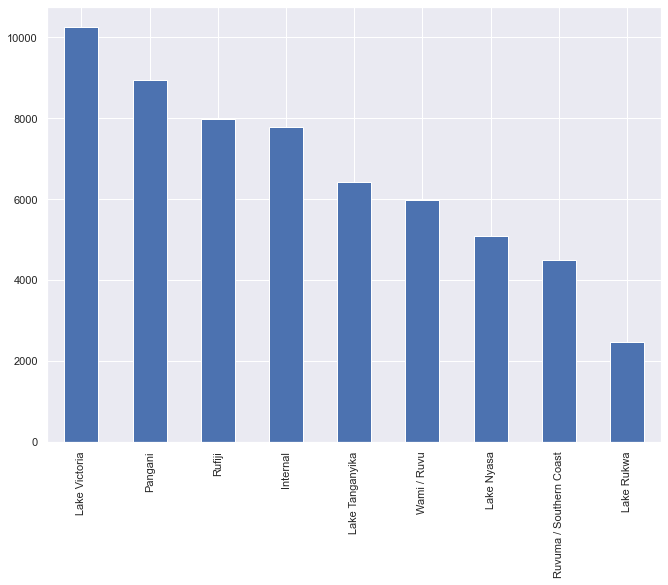

In [19]:
df_train.basin.value_counts().plot(kind='bar')

Perfect. **OHE**

### sub-village

In [21]:
df_train.subvillage.value_counts()

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
             ... 
Ng'Hona         1
Isagalla A      1
Usawini         1
Kigore          1
Kipeke          1
Name: subvillage, Length: 19287, dtype: int64

19k distinct values. **drop**

### Region & Region Code

In [26]:
df_train.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [27]:
df_train.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

Prefer region. Fewer columns. More readable. Might be able to cross lookup with geojson files as well. 

**OHE** region. **Drop** region_code

### District Code

<AxesSubplot:>

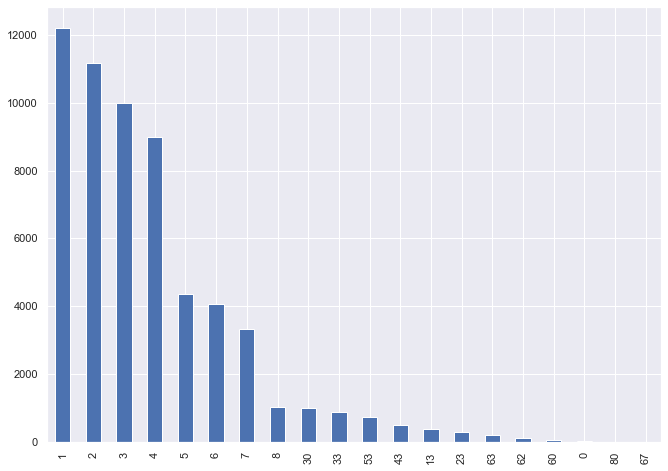

In [31]:
df_train.district_code.value_counts().plot(kind='bar')

In [36]:
len(df_train.district_code.unique())

20

**OHE** to keep or **Drop**? Both seem fairly viable
Don't use as numerical. Although it does look like smaller the number the more frequent it is used.

### lga

In [39]:
df_train.lga.value_counts(normalize=True)

Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: lga, Length: 125, dtype: float64

125 distinct values. Not worth the extra computation after OHE. **Drop**

### ward

In [40]:
df_train.ward.value_counts(normalize=True)

Igosi              0.005168
Imalinyi           0.004242
Siha Kati          0.003906
Mdandu             0.003889
Nduruma            0.003653
                     ...   
Ifinga             0.000017
Ukata              0.000017
Kapilula           0.000017
Sungwisi           0.000017
Uwanja wa Ndege    0.000017
Name: ward, Length: 2092, dtype: float64

2092 distinct values. Not worth the extra computation after OHE. **Drop**

### population

In [69]:
df_train.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [70]:
df_train.population.value_counts(normalize=True)

0       0.359949
1       0.118266
200     0.032660
150     0.031852
250     0.028300
          ...   
3241    0.000017
1960    0.000017
1685    0.000017
2248    0.000017
1439    0.000017
Name: population, Length: 1049, dtype: float64

Nearly 36% of well water sites have a population of **0** around it?? Find that hard to believe

In [64]:
df_train.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

<AxesSubplot:>

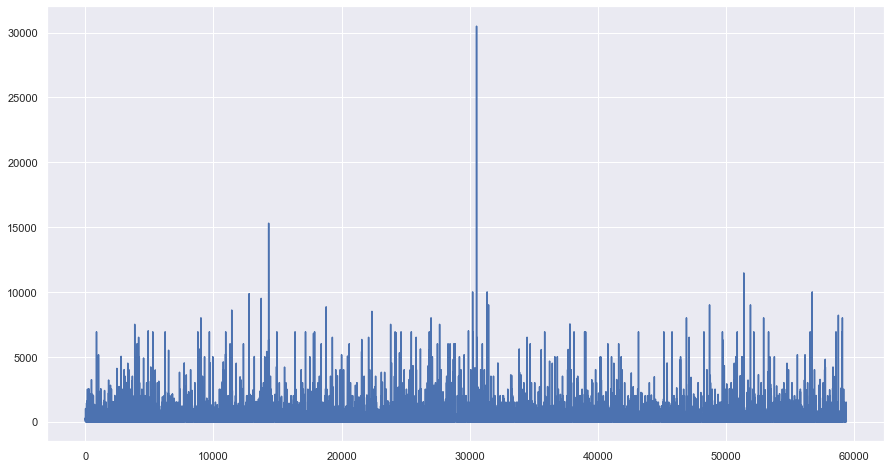

In [67]:
df_train.population.plot(kind='line',figsize=(15,8))

Not comfortable imputing zeroes (a third of our dataset) in this scenario. Plus there is always a possibility that the wells may not have a population around them.
Median = 25
Number of wells with 0 pop = 21381

If we impute in the median for these zero values

In [73]:
25*21381/df_train.population.sum()

0.050017999087272697

We'd be increasing the overall population of the entire dataset by 5%. **Drop**

### public_meeting

In [60]:
df_train.public_meeting.unique()

array([True, nan, False], dtype=object)

In [61]:
df_train.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

**Impute** nan with mode (True). Binary, no need to **OHE**

### scheme_management

In [77]:
df_train.scheme_management.isna().sum()/df_train.shape[0]

0.06526936026936027

6% missing data

In [81]:
df_train.scheme_management.value_counts(normalize=True)

VWC                 0.662662
WUG                 0.093763
Water authority     0.056787
WUA                 0.051924
Water Board         0.049493
Parastatal          0.030258
Private operator    0.019145
Company             0.019109
Other               0.013796
SWC                 0.001747
Trust               0.001297
None                0.000018
Name: scheme_management, dtype: float64

**Impute** with mode. **OHE**

### scheme_name

In [83]:
df_train.scheme_name.isna().sum()/df_train.shape[0]

0.4741750841750842

In [85]:
df_train.scheme_name.value_counts()

K                            682
None                         644
Borehole                     546
Chalinze wate                405
M                            400
                            ... 
Matiganjola hydram Scheme      1
BL K puchini Sisters           1
AMRSF                          1
Namba 7 dam                    1
Halmashauri                    1
Name: scheme_name, Length: 2696, dtype: int64

47% missing values and 2700 distinct labels. **Drop**

### permit

In [88]:
df_train.permit.isna().sum()/df_train.shape[0]

0.05144781144781145

5% data missing

In [89]:
df_train.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

**Impute** with mode ('True'). Binary, no need to OHE

### construction_year

In [94]:
(df_train.construction_year==0).sum()/df_train.shape[0]

0.34863636363636363

34.8% of data is filled with zeroes

In [95]:
df_train.construction_year.median()

1986.0

In [122]:
df_train[df_train.construction_year>0].construction_year.median()

2000.0

In [118]:
df_train[(df_train.construction_year==0)].status_group.value_counts(normalize=True)

functional                 0.509682
non functional             0.403931
functional needs repair    0.086388
Name: status_group, dtype: float64

In [125]:
for year in [1960, 1970, 1980, 1990, 2000, 2010]:
    print('-'*64)
    #subset by decade
    sub = df_train[(df_train.construction_year > year) &
                   (df_train.construction_year < year+10)]
    print(f'Constructed between {year} and {year+10}: Total count {sub.shape[0]}')
    print(sub.status_group.value_counts(normalize=True))

----------------------------------------------------------------
Constructed between 1960 and 1970: Total count 436
non functional             0.614679
functional                 0.302752
functional needs repair    0.082569
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1970 and 1980: Total count 3995
non functional             0.589487
functional                 0.327159
functional needs repair    0.083354
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1980 and 1990: Total count 4767
non functional             0.512272
functional                 0.411580
functional needs repair    0.076149
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1990 and 2000: Total count 6724
functional                 0.546252
non functional             0.385485
functional needs repair    0.068

Target statistics for homes with a construction year of zero are most similar to 1990-2000s.\
**Replace** 0 with median (2000)

### Extraction_type and Extraction_type_group

Almost identical

In [134]:
df_train.extraction_type.value_counts(normalize=True)

gravity                      0.450842
nira/tanira                  0.137273
other                        0.108249
submersible                  0.080202
swn 80                       0.061785
mono                         0.048232
india mark ii                0.040404
afridev                      0.029798
ksb                          0.023822
other - rope pump            0.007593
other - swn 81               0.003855
windmill                     0.001970
india mark iii               0.001650
cemo                         0.001515
other - play pump            0.001431
walimi                       0.000808
climax                       0.000539
other - mkulima/shinyanga    0.000034
Name: extraction_type, dtype: float64

<AxesSubplot:>

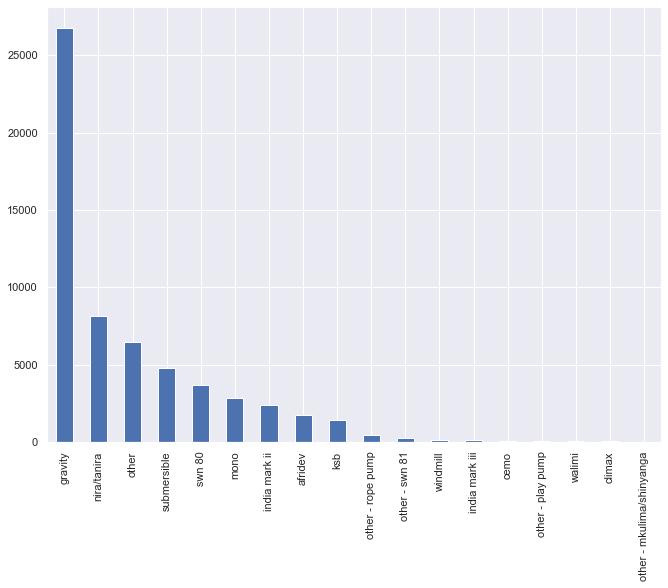

In [139]:
df_train.extraction_type.value_counts().plot(kind='bar')

In [132]:
df_train.extraction_type_group.value_counts(normalize=True)

gravity            0.450842
nira/tanira        0.137273
other              0.108249
submersible        0.104024
swn 80             0.061785
mono               0.048232
india mark ii      0.040404
afridev            0.029798
rope pump          0.007593
other handpump     0.006128
other motorpump    0.002054
wind-powered       0.001970
india mark iii     0.001650
Name: extraction_type_group, dtype: float64

<AxesSubplot:>

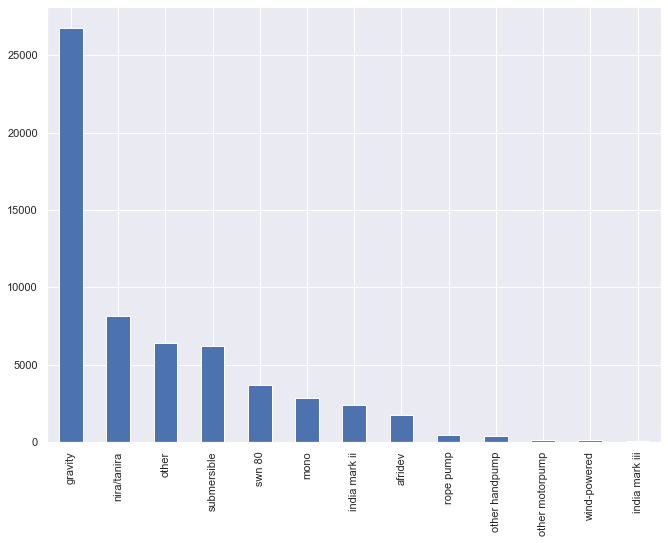

In [138]:
df_train.extraction_type_group.value_counts().plot(kind='bar')

In [135]:
df_train.extraction_type_class.value_counts(normalize=True)

gravity         0.450842
handpump        0.277037
other           0.108249
submersible     0.104024
motorpump       0.050286
rope pump       0.007593
wind-powered    0.001970
Name: extraction_type_class, dtype: float64

<AxesSubplot:>

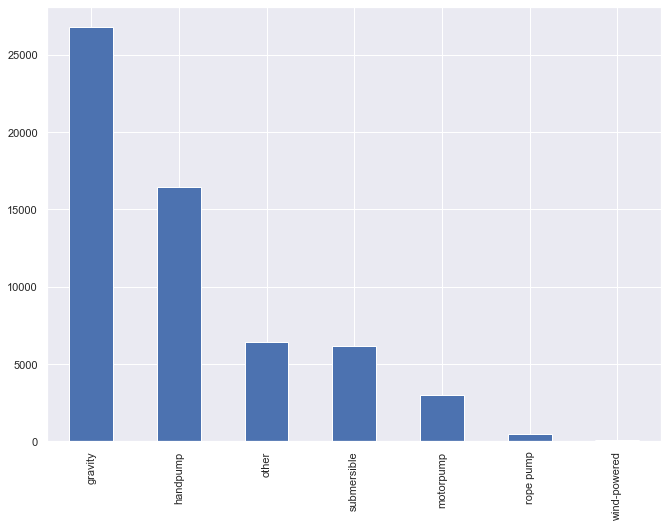

In [137]:
df_train.extraction_type_class.value_counts().plot(kind='bar')

Data is a lot less skewed in the last (smallest) of these sub groups. 

**Drop** Extraction_type\
**Drop** Extraction_type_group\
**OHE** Extraction_type_class

### Management and Management Group

In [144]:
df_train.management.value_counts(normalize=True)

vwc                 0.681936
wug                 0.109680
water board         0.049377
wua                 0.042677
private operator    0.033182
parastatal          0.029764
water authority     0.015219
other               0.014209
company             0.011532
unknown             0.009444
other - school      0.001667
trust               0.001313
Name: management, dtype: float64

<AxesSubplot:>

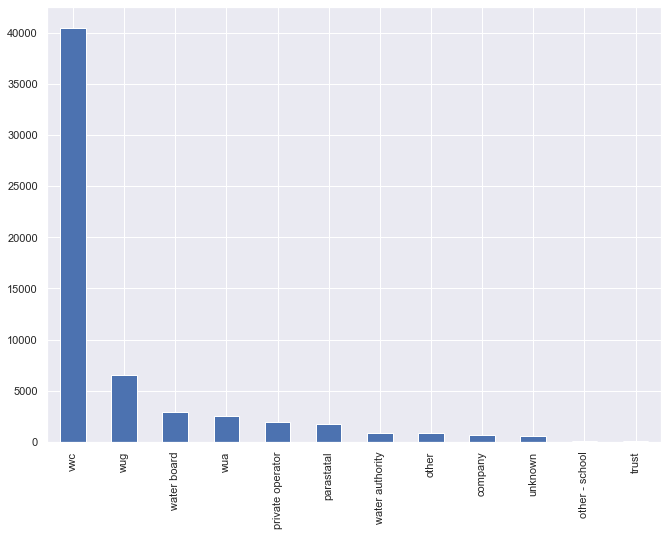

In [142]:
df_train.management.value_counts().plot(kind='bar')

In [145]:
df_train.management_group.value_counts(normalize=True)

user-group    0.883670
commercial    0.061246
parastatal    0.029764
other         0.015875
unknown       0.009444
Name: management_group, dtype: float64

<AxesSubplot:>

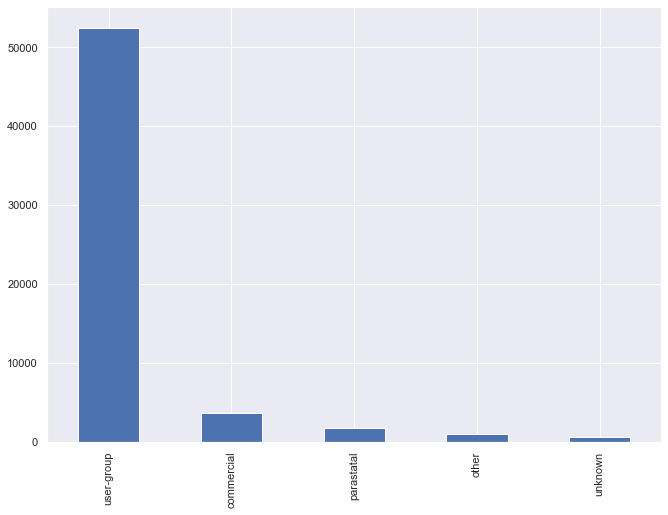

In [148]:
df_train.management_group.value_counts().plot(kind='bar')

Both are pretty skewed, but former is better. 

**Drop** Management_group\
**OHE** Management

### Payment and Payment Group

In [152]:
df_train.payment.value_counts(normalize=True)

never pay                0.426734
pay per bucket           0.151263
pay monthly              0.139731
unknown                  0.137323
pay when scheme fails    0.065892
pay annually             0.061313
other                    0.017744
Name: payment, dtype: float64

In [154]:
df_train.payment_type.value_counts(normalize=True)

never pay     0.426734
per bucket    0.151263
monthly       0.139731
unknown       0.137323
on failure    0.065892
annually      0.061313
other         0.017744
Name: payment_type, dtype: float64

Exactly identical. Prefer wording on first

**Drop** payment_type\
**OHE** payment

### Water Quality and Quality Group

In [161]:
df_train.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [160]:
df_train.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

Salty abandoned and Salty combined, fluoride and and fluoride abandoned are combined in 2nd set.

**Drop** water_quality
**OHE** quality_group

### Quantity and Quantity_group

In [163]:
df_train.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [164]:
df_train.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

*Exactly* the same. 

**Drop** quantity_group
**OHE** quantity

### Source and Source_Type

In [166]:
df_train.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [167]:
df_train.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

### Source Class

In [169]:
df_train.source_class.value_counts(normalize=True)

groundwater    0.770943
surface        0.224377
unknown        0.004680
Name: source_class, dtype: float64

'unknown' comprises less than 0.5% of the dataset. \
**Impute** with mode. \
**OHE** to get binary column

### waterpoint_type and waterpoint_type_group

In [173]:
df_train.waterpoint_type.value_counts(normalize=True)

communal standpipe             0.480168
hand pump                      0.294411
other                          0.107407
communal standpipe multiple    0.102744
improved spring                0.013199
cattle trough                  0.001953
dam                            0.000118
Name: waterpoint_type, dtype: float64

In [174]:
df_train.waterpoint_type_group.value_counts(normalize=True)

communal standpipe    0.582912
hand pump             0.294411
other                 0.107407
improved spring       0.013199
cattle trough         0.001953
dam                   0.000118
Name: waterpoint_type_group, dtype: float64

Fairly similar, with the second combing communal standpipe and communal standpipe multiple.

**Drop** waterpoint_type
**OHE** waterpoint_type_group

# Branch here for Flatiron or DrivenData
For Flatiron do a train test split to get your new X_train, X_test, y_train,y_test
For DrivenData copy X_train_raw, X_test_raw and y_train_raw to new X_train, X_test, y_train. Submit y_test

In [ ]:
df_train[df_train.public_meeting==True].status_group.value_counts(normalize=True)

In [ ]:
df_train.isna().sum()

In [ ]:
imp_missing = SimpleImputer(strategy='constant', fill_value='Missing',add_indicator=True)
ct = ColumnTransformer(transformers= 
                      [
                          ('missing_imp',imp_missing,['funder','installer'])
                      ],
                      remainder='passthrough')
X_train = ct.fit_transform(X_train_raw)
pd.DataFrame(
    X_train,
    columns = ct.get_feature_names_out(),
#     index = X_train_raw.index
            )

In [ ]:
df_train.drop(columns = ['latitude','longitude','id'])

In [ ]:
X_test_raw[X_test_raw.longitude==0]

In [ ]:
region_from_df = list(set(df.region.str.lower().to_list()))
region_from_df

In [ ]:
for each in region_from_df:
    if each not in adm1_list:
        print(each)

# MAP STUFF. IGNORE FOR NOW

In [ ]:
with open('data/stanford-tn398yw9512-geojson_districtBoundary.json', 'r',encoding='utf8') as f:
    geoJSON_raw = json.load(f)

In [ ]:
adm1_list_gjson = list(set([each['properties']['adm1'].replace('-', ' ').lower() for each in geoJSON_raw['features']]))
# adm2_list_gjson = list(set([each['properties']['adm2'].replace('-', ' ').lower() for each in geoJSON_raw['features']]))

In [ ]:
map_shape = shape(geoJSON_raw['features'][0]['geometry'])

In [ ]:
m=folium.Map(location=Tanzania_coord, zoom_start=5, tiles='CartoDB positron')
geo_j = folium.GeoJson(data=geoJSON_raw,
                           style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)

for each in df_high_head.iterrows():
    folium.Marker(
#         location=[each[1]['latitude'], each[1]['longitude']],
        location=(each[1]['latitude'],each[1]['longitude']),
        icon=folium.Icon(color="blue",icon="tint", prefix='fa')
    ).add_to(m)

m

# LAT and LONG

Some are marked as (lat,long) = (-2*e-8, 0) ~ (0,0) . In other words, location is missing.

1812 records ~ 3.050505 %

In [ ]:
X_train.loc[(abs(X_train.longitude) <0.05) & (abs(X_train.latitude) <0.05)].region.unique()

In [ ]:
X_train[X_train.region=='Shinyanga']

In [ ]:
df_high_head = X_train[X_train.amount_tsh>10000]

In [ ]:
# X_train['lon_lat'] = tuple(zip(X_train['longitude'], X_train['latitude']))
# X_train['inside_Tanzania_border'] = X_train['lon_lat'].map(lambda x : tanzania_shape.contains(Point(x)))

In [ ]:
# X_train_notInTanzania_minus00 = X_train.loc[
#     (X_train.inside_Tanzania_border == False) &
#     (abs(X_train.longitude) > 0.05) &
#     (abs(X_train.latitude) > 0.05)
#            ]
# X_train_notInTanzania_minus00

In [ ]:
# X_train.to_csv('data/X_train.csv')

# amount_tsh
total static head has no negative values. 
0 = outlet same level as inlet (assuming no inlet and outlet pressures other than head)
-ve = outlet lower than inlet. why pump? maybe hand pumps? (assuming no inlet and outlet pressures other than head)
+ve = outlet higher than inlet. (assuming no inlet and outlet pressures other than head)

In [ ]:
X_train[X_train.amount_tsh>10000].index

In [ ]:
y_train.iloc[X_train[X_train.amount_tsh>1].index,:].status_group.value_counts(normalize=True)

# NULLS

In [ ]:
# Columns with nulls
X_train.isna().sum()

In [ ]:
X_train.shape[0]

In [ ]:
X_train.village.isna().sum()

In [ ]:
X_train.subvillage.isna().sum()

In [ ]:
X_train.describe()

In [ ]:
df = pd.merge(X_train,y_train,on='id')

In [ ]:
df.select_dtypes(np.number)

In [ ]:
df = pd.DataFrame.copy(X_train)
df.drop(columns = ['id','longitude','latitude','gps_height'])
df

In [ ]:
df['water_quality | quality_grup']= df.water_quality + df.quality_group

In [ ]:
df['water_quality'].value_counts()

In [ ]:
df['quality_group'].value_counts()

In [ ]:
df['water_quality | quality_grup'].value_counts()

In [ ]:
df['wpt_type_to_wpt_type_grp'] = df.waterpoint_type +  df.waterpoint_type_group

In [ ]:
df.waterpoint_type.value_counts()

In [ ]:
df.waterpoint_type_group.value_counts()

In [ ]:
df.funder.value_counts()

In [ ]:
df.installer.value_counts()

In [ ]:
sns.heatmap(df.corr(),annot= True)

In [ ]:
df.gps_height.sort_values()

In [ ]:
df_highest = df[df.gps_height>2500].sort_values(by='gps_height')

In [ ]:
df_highest.status_group

In [ ]:
import folium

m = folium.Map(location = (-2.000000e-08,0), tiles = "Stamen Watercolor", zoom_start = 10)
number_of_markers = 100
i=0
for each in df_highest.iterrows():    
    folium.Marker(
        location=[each[1]['latitude'], each[1]['longitude']],
        icon=folium.Icon(color="green",icon="money", prefix='fa')
    ).add_to(m)
        
m

# New heading